In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import sklearn

from tqdm import tqdm
import folium
import webbrowser
import requests
import chardet

from matplotlib import pyplot as plt
import seaborn as sns


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

pd.options.mode.chained_assignment = None

노인의 삶의 질 계량화
- 개인의 삶의 질 Score
- 전체 삶의 질 Score
- 세대에 대한 조정이 반영된 전체 삶의 질 Score

In [2]:
temp = pd.read_csv('data/population_sample.csv')
region_code_dict = {int(x.split(' ')[0]):x.split(' ')[1] for x in np.unique(temp['A 행정구역(시군구)별'])}
region_code_dict[27] = 'Nan'

In [3]:
data_listing = {
    # Personal factors
    'person_age': 'A002_age', # 나이
    'person_birth_year': 'A002y', # 출생년도
    'person_gender': 'gender1', # 성별
    'person_residence_type': 'enu_type', # 거주형태
    'person_region1': 'region1', # 지역 코드
    'person_region3': 'region3', # 대도시/중소도시/읍면부 구분

    # Subjective
    'subj_health_condition': 'G026', # 주관적 건강상태
    'subj_financial_condition': 'G027', # 주관적 경제상태
    'subj_relationship_spouse': 'G028', # 배우자와의 관계
    'subj_relationship_children': 'G029', # 자녀와의 관계
    'subj_satisfaction': 'G030', # 전반적인 삶의 질
    
    # Objective
    # Health Status - Physical
    'healthp_disabled': 'C003', # 의사의 장애판정 여부: 1 Yes, 5 No
    'healthp_restriction': 'C005', # 건강상태로 인한 활동 제한: 1,2,3,4
    'healthp_pain': 'C102', # 통증으로 인한 일상 활동의 어려움 여부: 1 Yes, 5 No
    'healthp_excercise': 'C108', # 규칙적 운동 여부 (일주일 1회 이상)
    'healthp_ADL': 'adl', # ADL (기본적 일상생활 수행능력) 지수화
    'healthp_IADL': 'iadl', # IADL (도구적 일상활동 수행능력) 지수화

    # Health Status - Mental
    'healthm_depression1': 'C142', # 지난 1주일간 느낌과 행동_평소일에 대한 귀찮고 괴로운 느낌
    'healthm_depression2': 'C143', # 지난 1주일간 느낌과 행동_정신집중의 어려움
    'healthm_depression3': 'C144', # 지난 1주일간 느낌과 행동_우울감
    'healthm_depression4': 'C145', # 지난 1주일간 느낌과 행동_모든일에 대한 힘든 느낌
    'healthm_depression5': 'C146', # 지난 1주일간 느낌과 행동_비교적 잘 지내고 있다는 생각
    'healthm_depression6': 'C147', # 지난 1주일간 느낌과 행동_사람들이 나를 싫어하는 느낌
    'healthm_depression7': 'C148', # 지난 1주일간 느낌과 행동_수면장애
    'healthm_depression8': 'C149', # 지난 1주일간 느낌과 행동_큰 불만없이 생활했다는 생각
    'healthm_depression9': 'C150', # 지난 1주일간 느낌과 행동_세상에 홀로 있다는 외로움
    'healthm_depression10': 'C151', # 지난 1주일간 느낌과 행동_도무지 무얼 해나갈 엄두가 나지 않음

    # Financial Status
    'financial_hhassets': 'hhassets', # 가구 총자산
    'financial_hhinc': 'hhinc', # 가구 총소득
    
    # Social Connection
    'social_travel': 'G033', # 지난 1년간 여행, 관광, 나들이 경험 횟수
    'social_curtural': 'G035', # 지난 1년간 영화, 공연, 음악회 등의 관람 횟수
    'social_habbit': 'G037', # 지난 1년간 취미 및 오락 관련 모임 월 평균 참여 시간
    'social_self_develop': 'G039', # 지난 1년간 능력개발 교육 프로그램 월평균 참여시간
    'social_volunteer': 'G041', # 지난 1년간 자원봉사활동 월평균 참여시간
}

# Categorize keys
keys_person = [x for x in list(data_listing.keys()) if x.split('_')[0]=='person']
keys_subj = [x for x in list(data_listing.keys()) if x.split('_')[0]=='subj']
keys_healthp = [x for x in list(data_listing.keys()) if x.split('_')[0]=='healthp']
keys_healthm = [x for x in list(data_listing.keys()) if x.split('_')[0]=='healthm']
keys_financial = [x for x in list(data_listing.keys()) if x.split('_')[0]=='financial']
keys_social = [x for x in list(data_listing.keys()) if x.split('_')[0]=='social']


In [4]:
def get_ith_data(i):
    df1 = pd.read_csv('data/KLoSA_EXCEL/Lt0%s.csv' % str(i))
    df2 = pd.read_csv('data/KLoSA_EXCEL/str0%s.csv' % str(i))
    df = pd.merge(df1, df2, how='outer', on=list(set(df1.columns).intersection(set(df2.columns))))
    df = df.loc[:, ['w0%s' % i + x for x in list(data_listing.values())]] # Get sellected columns
    return df

In [5]:
def gen_score(df_i, i):
    ### Data Preprocessing ###
    # Personal
    df_personal = df_i.loc[:, ['w0%s' % i + data_listing[key] for key in keys_person]]
    df_personal['age_interval'] = df_personal['w0%s' % i + 'A002_age']//5 * 5
    df_personal['birth_interval'] = df_personal['w0%s' % i + 'A002y']//5 * 5

    # Subjective 
    df_subj = df_i.loc[:, ['w0%s' % i + data_listing[key] for key in keys_subj]]
    df_subj = df_subj.applymap(lambda x: np.nan if x < 0 else x)
    # df_subj = df_subj.apply(lambda row: row.fillna(row.mean()), axis=1)
    df_subj = df_subj.apply(lambda col: col.fillna(col.mean()), axis=0)
    df_subj = df_subj/100
    df_subj['score_subjective'] = df_subj.mean(axis=1)

    # Health Status - Physical
    df_heatlhp = df_i.loc[:, ['w0%s' % i + data_listing[key] for key in keys_healthp]]
    df_heatlhp = df_heatlhp.applymap(lambda x: np.nan if x < 0 else x)
    df_heatlhp.loc[:, 'w0%s' % i + 'C003'] = df_heatlhp.loc[:, 'w0%s' % i + 'C003'].apply(lambda x: 3 if np.isnan(x) else x)
    df_heatlhp.loc[:, 'w0%s' % i + 'C102'] = df_heatlhp.loc[:, 'w0%s' % i + 'C102'].apply(lambda x: 3 if np.isnan(x) else x)
    df_heatlhp.loc[:,'w0%s' % i + 'adl'] = df_heatlhp.loc[:,'w0%s' % i + 'adl'].apply(lambda x: 7-x)
    df_heatlhp.loc[:,'w0%s' % i + 'iadl'] = df_heatlhp.loc[:,'w0%s' % i + 'iadl'].apply(lambda x: 10-x)
    df_heatlhp = df_heatlhp.apply(lambda col: col.fillna(col.mean()), axis=0)
    df_heatlhp = df_heatlhp / df_heatlhp.max(axis=0)
    df_heatlhp['score_healthp'] = df_heatlhp.mean(axis=1)

    # Health Status - Mental
    df_heatlhm = df_i.loc[:, ['w0%s' % i + data_listing[key] for key in keys_healthm]]
    df_heatlhm = df_heatlhm.applymap(lambda x: np.nan if x < 0 else x)
    inverse_order = ['w0%s' % i + data_listing[key] for key in ['healthm_depression5', 'healthm_depression8']]
    df_heatlhm.loc[:,inverse_order] = df_heatlhm.loc[:,inverse_order].applymap(lambda x: 5-x)
    # df_heatlhm = df_heatlhm.apply(lambda row: row.fillna(row.mean()), axis=1)
    df_heatlhm = df_heatlhm.apply(lambda col: col.fillna(col.mean()), axis=0)
    df_heatlhm = df_heatlhm/4
    df_heatlhm['score_healthm'] = 1 - np.nanmean(df_heatlhm, axis=1)

    # Financial Status
    df_finance = df_i.loc[:, ['w0%s' % i + data_listing[key] for key in keys_financial]]
    df_finance = df_finance.applymap(lambda x: np.nan if x < 0 else x)
    df_finance = df_finance.rank(pct=True)
    # df_finance = df_finance.apply(lambda row: row.fillna(row.mean()), axis=1)
    df_finance = df_finance.apply(lambda col: col.fillna(col.mean()), axis=0)
    df_finance['score_finance'] = np.nanmean(df_finance, axis=1)

    # Social Connection
    df_social = df_i.loc[:, ['w0%s' % i + data_listing[key] for key in keys_social]]
    df_social = df_social.applymap(lambda x: np.nan if x < 0 else x)
    df_social = df_social.rank(pct=True)
    # df_social = df_social.apply(lambda row: row.fillna(row.mean()), axis=1)
    df_social = df_social.apply(lambda col: col.fillna(col.mean()), axis=0)
    df_social['score_social'] = df_social.mean(axis=1)

    ### Score Calculating ###
    df_score = pd.concat([
        df_personal,
        df_subj,
        df_heatlhp, 
        df_heatlhm,
        df_finance,
        df_social
    ], axis=1)

    df_score['score'] = (
        df_score['score_subjective']/2 
        + (df_score['score_healthp'] + df_score['score_healthm'] + df_score['score_finance'] + df_score['score_social'])/8
    )

    return df_score

def calculate_atkinson_inequality(values, epsilon=0.5):
    n = len(values)
    if n <= 1:
        return 0
    mean = np.mean(values)
    sum_term = sum((x/mean)**(1-epsilon) for x in values) / n
    return 1 - (sum_term ** (1/(1-epsilon)))

def life_quality(values, epsilon=0.5):
    inequality = calculate_atkinson_inequality(values, epsilon)
    return np.mean(values) * (1-inequality)

def life_quality_sep(values, epsilon=0.5):
    inequality = calculate_atkinson_inequality(values, epsilon)
    average = np.mean(values)
    return average, inequality, average * (1-inequality)

def calculate_atkinson_inequality_intra_group(values_by_group, epsilon=0.5):
    group_inequalities = []
    for values in values_by_group:
        group_inequality = calculate_atkinson_inequality(values, epsilon)
        group_inequalities.append(group_inequality)
    overall_inequality = np.mean(group_inequalities)
    return overall_inequality

def life_quality_weighted(values_by_group, epsilon=0.5):
    representatives = [np.mean(values) for values in values_by_group]
    inter_average, inter_inequality, _ = life_quality_sep(representatives, epsilon)
    intra_inequality = calculate_atkinson_inequality_intra_group(values_by_group, epsilon)
    return inter_average, inter_inequality, intra_inequality, inter_average * (1 - inter_inequality - intra_inequality)

In [6]:
df = {}
df_scores = {}
heatlhm = []
for i in tqdm(range(2, 10)):
    df[i] = get_ith_data(i)  
    df_scores[i] = gen_score(df[i], i)         # Generate the score dataframe for the ith dataset
    df_scores[i].to_csv(f'data/refined/score_{i}.csv', index=False)  # Save to CSV

100%|██████████| 8/8 [00:15<00:00,  1.95s/it]


,0,1,2,3,4,5,6,7
G026,0.528284,0.530537,0.534852,0.558909,0.584479,0.574175,0.584433,0.580280
G027,0.490424,0.510060,0.524210,0.525740,0.559524,0.555402,0.569656,0.570551
G028,0.633779,0.631957,0.624627,0.625884,0.650795,0.645507,0.654521,0.650299
G029,0.650189,0.664749,0.643489,0.639076,0.666833,0.663079,0.674079,0.679051
G030,0.592315,0.595160,0.584835,0.595493,0.625284,0.622801,0.633644,0.628979
score_subjective,0.578998,0.586493,0.582403,0.589020,0.617383,0.612193,0.623267,0.621832


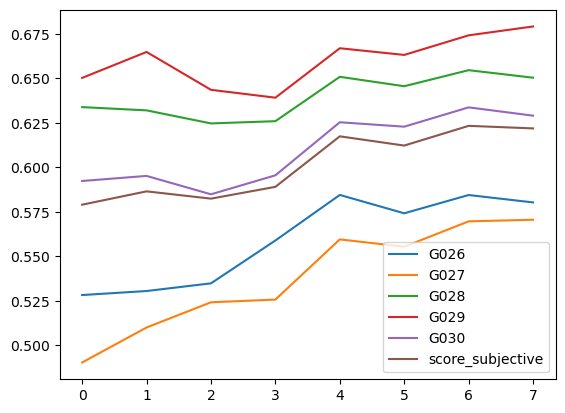

In [7]:
# Subjective
subj = []
for i in range(2, 10):
    df_subj = df[i].loc[:, ['w0%s' % i + data_listing[key] for key in keys_subj]]
    df_subj = df_subj.applymap(lambda x: np.nan if x < 0 else x)
    df_subj = df_subj.apply(lambda row: row.fillna(row.mean()), axis=1)
    df_subj = df_subj.apply(lambda col: col.fillna(col.mean()), axis=0)
    df_subj = df_subj/100
    df_subj['score_subjective'] = df_subj.mean(axis=1)

    avg = df_subj.mean()
    avg.index = [x[3:] if x[0] == 'w' else x for x in avg.index]
    subj.append(avg)
pd.concat(subj, axis=1).T.plot()
pd.concat(subj, axis=1).style.background_gradient(cmap='Blues', axis=1)

,0,1,2,3,4,5,6,7
C003,0.987869,0.987827,0.994761,0.992359,0.995586,0.994320,0.997779,0.994787
C005,0.666686,0.670685,0.654468,0.669491,0.677836,0.673204,0.678076,0.674389
C102,0.643656,0.650881,0.664183,0.696200,0.700459,0.690468,0.704471,0.709356
C108,0.719246,0.735292,0.717372,0.742566,0.720832,0.736804,0.669238,0.629717
adl,0.971032,0.964236,0.965355,0.967978,0.970399,0.968404,0.973587,0.966220
iadl,0.932876,0.929971,0.931525,0.932373,0.935430,0.938403,0.937544,0.922014
score_healthp,0.829255,0.832604,0.827851,0.840382,0.840383,0.841175,0.831996,0.819789


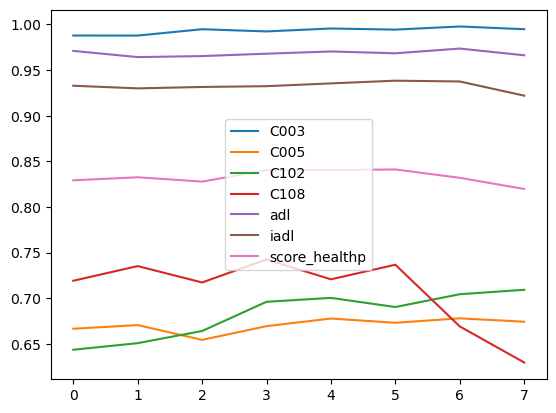

In [8]:
# Health Status - Physical
heatlhp = []
for i in range(2, 10):
    df_heatlhp = df[i].loc[:, ['w0%s' % i + data_listing[key] for key in keys_healthp]]
    df_heatlhp = df_heatlhp.applymap(lambda x: np.nan if x < 0 else x)
    df_heatlhp.loc[:,'w0%s' % i + 'adl'] = df_heatlhp.loc[:,'w0%s' % i + 'adl'].apply(lambda x: 7-x)
    df_heatlhp.loc[:,'w0%s' % i + 'iadl'] = df_heatlhp.loc[:,'w0%s' % i + 'iadl'].apply(lambda x: 10-x)
    df_heatlhp = df_heatlhp / df_heatlhp.max(axis=0)
    df_heatlhp['score_healthp'] = df_heatlhp.mean(axis=1)

    avg = df_heatlhp.mean()
    avg.index = [x[3:] if x[0] == 'w' else x for x in avg.index]
    heatlhp.append(avg)
pd.concat(heatlhp, axis=1).T.plot()
pd.concat(heatlhp, axis=1).style.background_gradient(cmap='Blues', axis=1)

In [9]:
# Health Status - Mental
heatlhm = []
for i in range(2, 10):
    df_heatlhm = df[i].loc[:, ['w0%s' % i + data_listing[key] for key in keys_healthm]]
    df_heatlhm = df_heatlhm.applymap(lambda x: np.nan if x < 0 else x)
    df_heatlhm = df_heatlhm / df_heatlhm.max(axis=0)
    df_heatlhm['score_healthp'] = df_heatlhm.mean(axis=1)

    avg = df_heatlhm.mean()
    avg.index = [x[3:] if x[0] == 'w' else x for x in avg.index]
    heatlhm.append(avg)
pd.concat(heatlhm, axis=1).style.background_gradient(cmap='Blues', axis=1)

,0,1,2,3,4,5,6,7
C142,0.406675,0.389195,0.379083,0.314928,0.299593,0.327554,0.307816,0.314077
C143,0.395729,0.387322,0.384844,0.374413,0.357712,0.364159,0.353575,0.366297
C144,0.392818,0.388823,0.382291,0.385339,0.374991,0.369361,0.359295,0.372946
C145,0.434784,0.415892,0.410568,0.429427,0.418082,0.393481,0.381716,0.405315
C146,0.625938,0.608649,0.587849,0.663180,0.662200,0.664272,0.695552,0.688759
C147,0.376036,0.382184,0.369629,0.337306,0.325635,0.351008,0.326371,0.343781
C148,0.404321,0.406931,0.396173,0.395213,0.372050,0.379875,0.369599,0.384999
C149,0.595460,0.573481,0.564479,0.632001,0.656561,0.648574,0.680664,0.665754
C150,0.389243,0.392132,0.378324,0.384590,0.363609,0.371053,0.360949,0.378692
C151,0.391607,0.387610,0.373955,0.382912,0.367212,0.366178,0.358837,0.377469


In [10]:
# Financial Status
finance = []
for i in range(2, 10):
    df_finance = df[i].loc[:, ['w0%s' % i + data_listing[key] for key in keys_financial]]
    df_finance = df_finance.applymap(lambda x: np.nan if x < 0 else x)
    df_finance = df_finance.rank(pct=True)
    df_finance = df_finance.apply(lambda row: row.fillna(row.mean()), axis=1)
    df_finance = df_finance.apply(lambda col: col.fillna(col.mean()), axis=0)
    df_finance['score_finance'] = np.nanmean(df_finance, axis=1)

    avg = df_finance.mean()
    avg.index = [x[3:] if x[0] == 'w' else x for x in avg.index]
    finance.append(avg)
pd.concat(finance, axis=1).style.background_gradient(cmap='Blues', axis=1)

,0,1,2,3,4,5,6,7
hhassets,0.497331,0.499112,0.500293,0.499517,0.500140,0.498357,0.499296,0.497863
hhinc,0.500487,0.500314,0.500077,0.501423,0.500154,0.499850,0.499878,0.500057
score_finance,0.498909,0.499713,0.500185,0.500470,0.500147,0.499104,0.499587,0.498960


In [11]:
# Social Connection
social = []
for i in range(2, 10):    
    df_social = df[i].loc[:, ['w0%s' % i + data_listing[key] for key in keys_social]]
    df_social = df_social.applymap(lambda x: np.nan if x < 0 else x)
    df_social = df_social.rank(pct=True)
    df_social = df_social.apply(lambda row: row.fillna(row.mean()), axis=1)
    df_social = df_social.apply(lambda col: col.fillna(col.mean()), axis=0)
    df_social['score_social'] = df_social.mean(axis=1)

    avg = df_social.mean()
    avg.index = [x[3:] if x[0] == 'w' else x for x in avg.index]
    social.append(avg)
pd.concat(social, axis=1).style.background_gradient(cmap='Blues', axis=1)

,0,1,2,3,4,5,6,7
G033,0.500058,0.500063,0.500067,0.500059,0.500049,0.500070,0.500074,0.500083
G035,0.500058,0.500063,0.500067,0.500092,0.500078,0.500106,0.500077,0.500083
G037,0.500058,0.500063,0.500067,0.500063,0.500157,0.500072,0.500077,0.500083
G039,0.500058,0.500063,0.500067,0.500063,0.500067,0.500072,0.500077,0.500083
G041,0.500058,0.500063,0.500067,0.500063,0.500067,0.500093,0.500077,0.500083
score_social,0.500058,0.500063,0.500067,0.500068,0.500084,0.500083,0.500076,0.500083


In [12]:
# Generate yearly score arrays
scores = []
score_subjective = []
score_healthp = []
score_healthm = []
score_finance = []
score_social = []

for i in range(2, 10):
    df_score = df_scores[i]       # Generate the score dataframe for the ith dataset
    
    # Append scores to their respective lists
    scores.append(df_score['score'])                       # Main score
    score_subjective.append(df_score['score_subjective'])  # Subjective score
    score_healthp.append(df_score['score_healthp'])        # Physical health score
    score_healthm.append(df_score['score_healthm'])        # Mental health score
    score_finance.append(df_score['score_finance'])        # Financial score
    score_social.append(df_score['score_social'])          # Social score
    

In [13]:
# Generate statistics for each score
score_dict = {
    'score': scores,
    'score_subjective': score_subjective,
    'score_healthp': score_healthp,
    'score_healthm': score_healthm,
    'score_finance': score_finance,
    'score_social': score_social
}

stats = []
age_scores = []
for score_type, score_list in score_dict.items():
    for year, score in enumerate(score_list, start=2):
        # Calculate descriptive statistics
        desc = score.describe()
        
        # Calculate skewness and kurtosis
        desc['skewness'] = skew(score, nan_policy='omit')
        desc['kurtosis'] = kurtosis(score, nan_policy='omit')
        
        # Calculate custom life quality metrics
        average, inequality, total_life_quality = life_quality_sep(score, 0.5)
        # desc['average_score'] = average
        desc['inequality'] = inequality
        desc['total_life_quality'] = total_life_quality
        
        # Add identifiers for score type and year
        desc['score_type'] = score_type
        desc['year'] = year

        # Append the descriptive stats to the stats list
        stats.append(desc)

score_stat = pd.DataFrame(stats)
score_stat.set_index(['score_type', 'year'], inplace=True)
score_stat

count      mean       std       min       25%  \
score_type       year                                                    
score            2     12891.0  0.593531  0.107871  0.197685  0.522892   
                 3     12255.0  0.595671  0.107037  0.126923  0.529967   
                 4     11962.0  0.594847  0.102697  0.175758  0.529609   
                 5     12362.0  0.602264  0.100559  0.223549  0.536756   
                 6     14377.0  0.617228  0.095567  0.132274  0.560032   
                 7     13754.0  0.614070  0.096687  0.217770  0.552473   
                 8     12548.0  0.620349  0.090646  0.212126  0.565299   
                 9     10230.0  0.616313  0.089770  0.224112  0.561547   
score_subjective 2     12891.0  0.595549  0.143903  0.000000  0.500000   
                 3     12255.0  0.599353  0.143362  0.000000  0.514536   
                 4     11962.0  0.597363  0.133909  0.000000  0.515970   
                 5     12362.0  0.604188  0.129872  0.120000  0.515829   
                 6     14377.0  0.630474  0.122474  0.000000  0.556594   
                 7     13754.0  0.625078  0.124733  0.000000  0.540000   
                 8     12548.0  0.635330  0.120392  0.100000  0.560000   
                 9     10230.0  0.633695  0.120981  0.136337  0.560000   
score_healthp    2     12891.0  0.812936  0.121572  0.208333  0.758333   
                 3     12255.0  0.814647  0.123886  0.208333  0.758333   
                 4     11962.0  0.811470  0.120774  0.275000  0.758333   
                 5     12362.0  0.822154  0.120117  0.208333  0.758333   
                 6     14377.0  0.821840  0.116426  0.208333  0.758333   
                 7     13754.0  0.823124  0.118710  0.141667  0.758333   
                 8     12548.0  0.815553  0.114759  0.208333  0.758333   
                 9     10230.0  0.804497  0.118867  0.225000  0.758333   
score_healthm    2     12891.0  0.553018  0.145483  0.000000  0.475000   
                 3     12255.0  0.553204  0.144267  0.000000  0.475000   
                 4     11962.0  0.557746  0.139245  0.000000  0.475000   
                 5     12362.0  0.579105  0.137443  0.000000  0.500000   
                 6     14377.0  0.593988  0.131934  0.000000  0.525000   
                 7     13754.0  0.589018  0.136507  0.025000  0.500000   
                 8     12548.0  0.605806  0.126372  0.000000  0.525000   
                 9     10230.0  0.591094  0.126769  0.000000  0.525000   
score_finance    2     12891.0  0.500040  0.242397  0.003201  0.310449   
                 3     12255.0  0.500042  0.242729  0.004297  0.307770   
                 4     11962.0  0.500042  0.243475  0.004622  0.310428   
                 5     12362.0  0.500041  0.244119  0.003338  0.307412   
                 6     14377.0  0.500035  0.243599  0.006189  0.303818   
                 7     13754.0  0.500037  0.243313  0.011101  0.310505   
                 8     12548.0  0.500040  0.241286  0.005126  0.308860   
                 9     10230.0  0.500049  0.241998  0.004039  0.308910   
score_social     2     12891.0  0.500058  0.063239  0.446812  0.446812   
                 3     12255.0  0.500063  0.060977  0.447537  0.447537   
                 4     11962.0  0.500067  0.062289  0.445317  0.445317   
                 5     12362.0  0.500063  0.071379  0.428912  0.428912   
                 6     14377.0  0.500067  0.064958  0.425497  0.425497   
                 7     13754.0  0.500072  0.065504  0.423284  0.491190   
                 8     12548.0  0.500077  0.059084  0.444415  0.444415   
                 9     10230.0  0.500083  0.060229  0.449381  0.449381   

                            50%       75%       max  skewness  kurtosis  \
score_type       year                                                     
score            2     0.603074  0.672032  0.901840 -0.402048 -0.101164   
                 3     0.609252  0.673039  0.905444 -0.548457  0.098222   
                 4     0

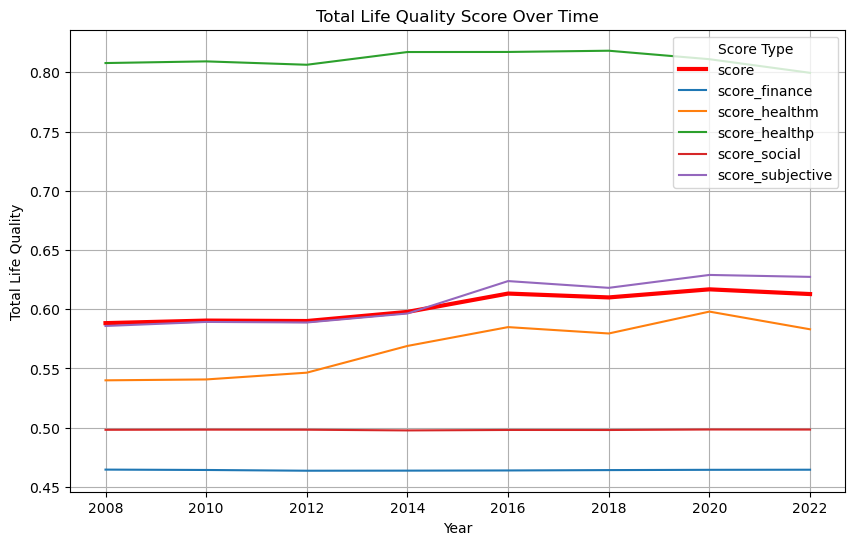

In [105]:
pivot_df_multi  = score_stat[['total_life_quality']].reset_index()
pivot_df_multi = pivot_df_multi.pivot(index='year', columns='score_type', values='total_life_quality')
pivot_df_multi.index = list(range(2008, 2024, 2))
pivot_df_multi

# Plotting the graph for all score types over time
plt.figure(figsize=(10, 6))
for column in pivot_df_multi.columns:
    if column == 'score':
        plt.plot(pivot_df_multi.index, pivot_df_multi[column], label=column, linewidth=3, c='r')    
    else:
        plt.plot(pivot_df_multi.index, pivot_df_multi[column], label=column)

plt.title('Total Life Quality Score Over Time')
plt.xlabel('Year')
plt.ylabel('Total Life Quality')
plt.legend(title='Score Type')
plt.grid(True)
plt.show()

In [106]:
pivot_df_multi

score_type,score,score_finance,score_healthm,score_healthp,score_social,score_subjective
2008,0.588277,0.464654,0.540009,0.807812,0.498251,0.585887
2010,0.590437,0.464340,0.540756,0.809222,0.498382,0.589309
2012,0.590056,0.463710,0.546470,0.806372,0.498324,0.588830
2014,0.597757,0.463783,0.569037,0.817114,0.497725,0.596435
2016,0.613247,0.463934,0.584925,0.817175,0.498113,0.623779
2018,0.609988,0.464240,0.579551,0.818217,0.498086,0.618079
2020,0.616809,0.464474,0.598021,0.811062,0.498503,0.628963
2022,0.612831,0.464555,0.583082,0.799561,0.498448,0.627331


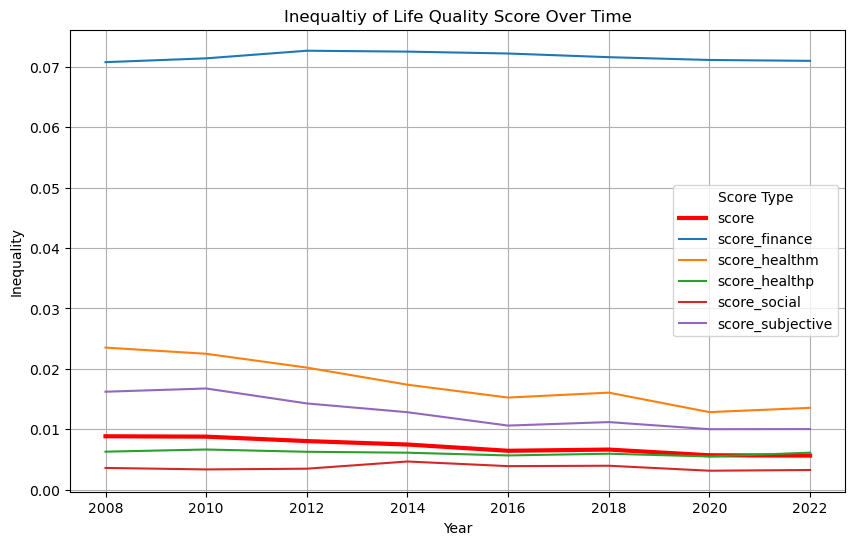

In [42]:
pivot_df_multi_ie  = score_stat[['inequality']].reset_index()
pivot_df_multi_ie = pivot_df_multi_ie.pivot(index='year', columns='score_type', values='inequality')
pivot_df_multi_ie.index = list(range(2008, 2024, 2))
pivot_df_multi_ie

# Plotting the graph for all score types over time
plt.figure(figsize=(10, 6))
for column in pivot_df_multi_ie.columns:
    if column == 'score':
        plt.plot(pivot_df_multi_ie.index, pivot_df_multi_ie[column], label=column, linewidth=3, c='r')    
    else:
        plt.plot(pivot_df_multi_ie.index, pivot_df_multi_ie[column], label=column)

plt.title('Inequaltiy of Life Quality Score Over Time')
plt.xlabel('Year')
plt.ylabel('Inequality')
plt.legend(title='Score Type')
plt.grid(True)
plt.show()

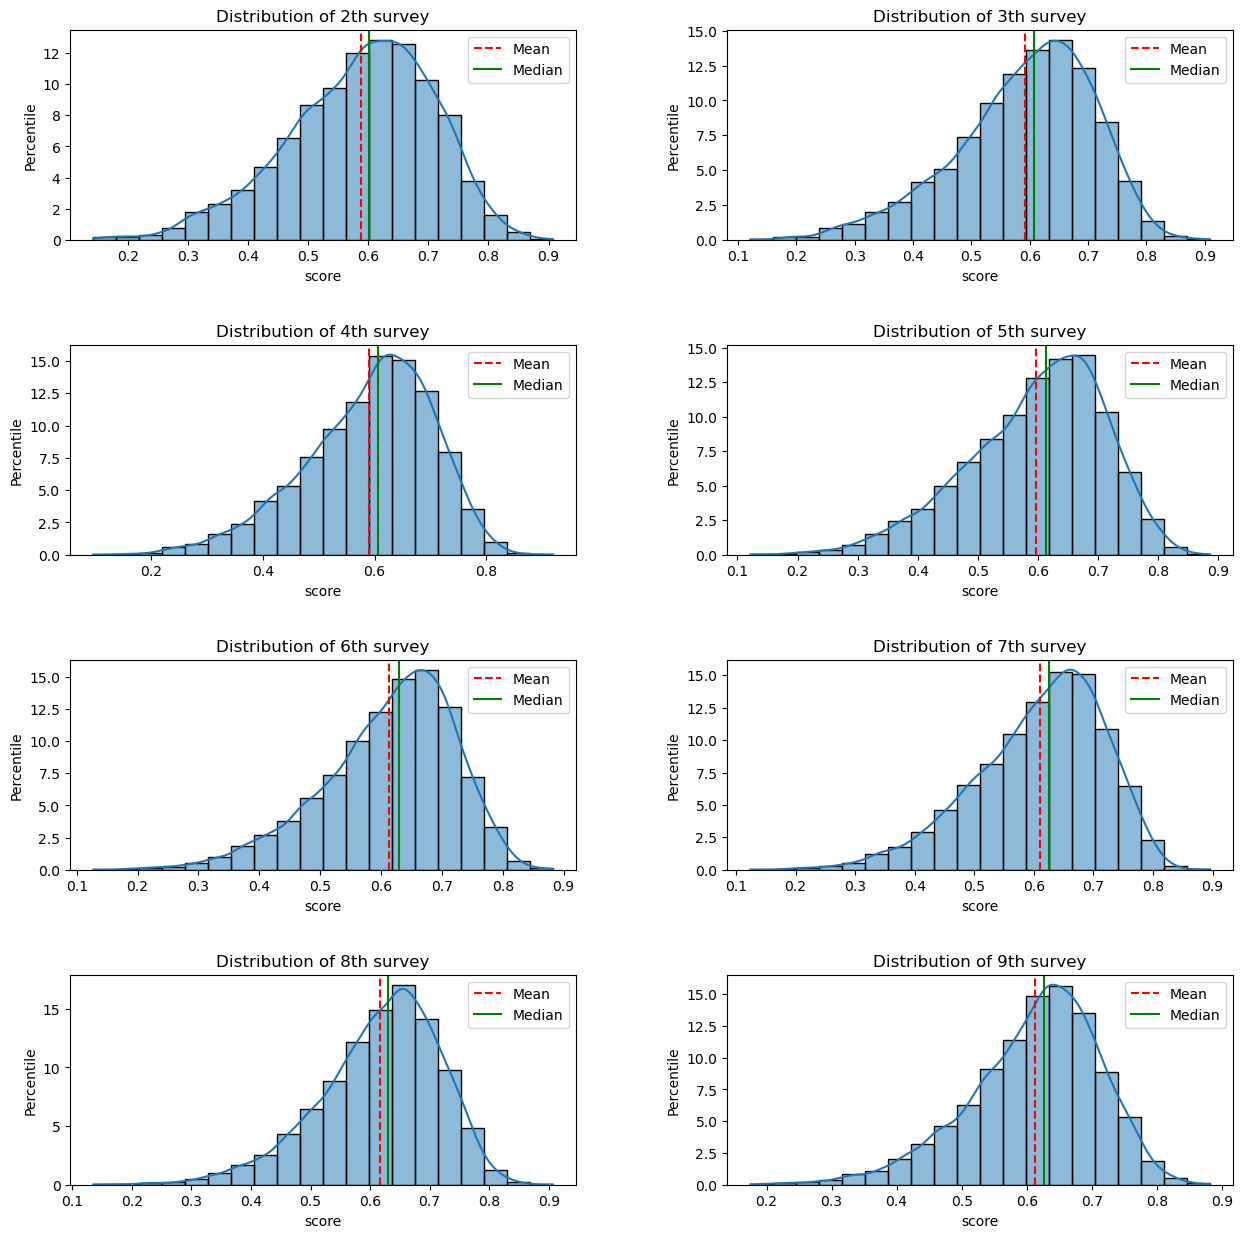

In [15]:
fig, axes = plt.subplots(nrows=4, ncols=len(scores)//4, figsize=(15, 15))
axes = axes.flatten()

for i, score in enumerate(scores):
    sns.histplot(score, kde=True, stat='percent', ax=axes[i], bins=20)
    axes[i].axvline(score.mean(), color='r', linestyle='--', label='Mean')
    axes[i].axvline(score.median(), color='g', linestyle='-', label='Median')
    axes[i].set_title(f"Distribution of {i+2}th survey")
    axes[i].set_ylabel('Percentile')  # Change Y-axis label to Percentile
    axes[i].legend()

plt.subplots_adjust(wspace=0.3, hspace=0.5)

,서울특별시,부산광역시,대구광역시,인천광역시,광주광역시,대전광역시,울산광역시,경기도,강원도,충청북도,충청남도,전라북도,전라남도,경상북도,경상남도,Nan
2008,0.582873,0.572966,0.599037,0.579892,0.612964,0.615798,0.617052,0.604153,0.598569,0.598128,0.604525,0.588551,0.558667,0.598190,0.594196,nan
2010,0.591914,0.587140,0.605519,0.566256,0.598241,0.627982,0.616296,0.600744,0.596233,0.617675,0.621280,0.578175,0.545706,0.604598,0.597585,nan
2012,0.589272,0.584946,0.602118,0.568749,0.597863,0.624174,0.613578,0.596761,0.610785,0.612165,0.615672,0.579614,0.553435,0.604941,0.597705,nan
2014,0.591013,0.598475,0.620660,0.575050,0.624133,0.644205,0.624395,0.592818,0.602336,0.611278,0.629432,0.589383,0.580590,0.614222,0.603973,0.517010
2016,0.611061,0.612347,0.639085,0.581513,0.632113,0.655720,0.640024,0.604442,0.603689,0.628586,0.638186,0.600524,0.598578,0.640096,0.620162,0.551077
2018,0.614723,0.605907,0.628250,0.598261,0.630304,0.665926,0.627270,0.601419,0.596343,0.617258,0.649643,0.588789,0.581274,0.633813,0.610348,0.589948
2020,0.621230,0.616459,0.636728,0.597702,0.629386,0.658208,0.623326,0.604848,0.633595,0.631320,0.647731,0.601962,0.591177,0.636068,0.615318,0.598976
2022,0.614021,0.617613,0.616388,0.569889,0.623980,0.658829,0.647559,0.602642,0.630327,0.635074,0.632513,0.606594,0.590722,0.625455,0.625091,0.566154


c:\Users\lamor\anaconda3\envs\old_health\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\lamor\anaconda3\envs\old_health\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 50872 (\N{HANGUL SYLLABLE UL}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\lamor\anaconda3\envs\old_health\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 53945 (\N{HANGUL SYLLABLE TEUG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\lamor\anaconda3\envs\old_health\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\lamor\anaconda3\envs\old_health\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\lamor\anaconda3

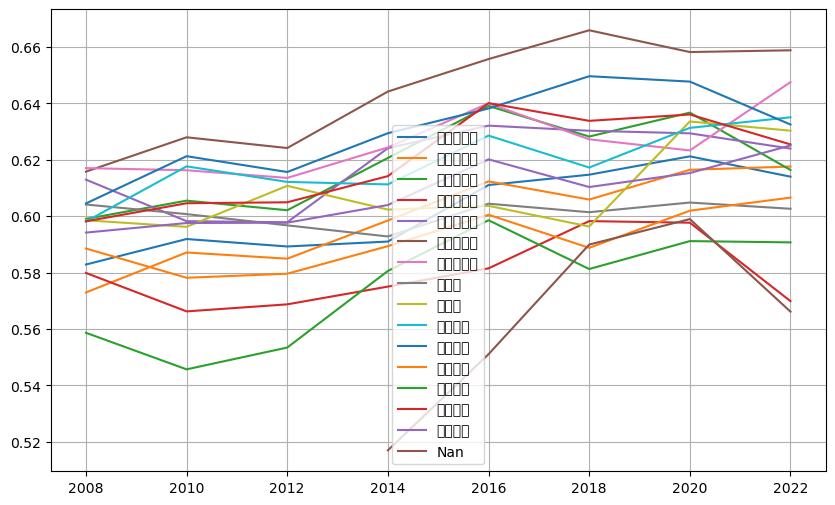

In [85]:
# Score Groupby Region
region_scores = []
for i in range(2, 10):
    region_score = df_scores[i].groupby(by='w0%s' % i +'region1')['score'].apply(lambda x: x.mean())
    region_score['year'] = i
    region_scores.append(region_score)
score_stat_region = pd.DataFrame(region_scores)
score_stat_region.set_index(['year'], inplace=True)
score_stat_region.index = list(range(2008, 2024, 2))
score_stat_region.columns = [region_code_dict[int(col)] for col in score_stat_region.columns]
score_stat_region.plot(grid=True, legend=True, figsize=(10, 6))
score_stat_region.style.background_gradient(cmap='Blues', axis=1)

age_interval,45,50,55,60,65,70,75,80,85,90,95,100,105
2008,0.647993,0.639893,0.626417,0.609451,0.582394,0.561663,0.548454,0.540263,0.529938,0.509786,0.531493,nan,nan
2010,0.648162,0.650517,0.638599,0.616012,0.591520,0.563057,0.553351,0.542526,0.546857,0.516218,0.495250,0.485002,nan
2012,nan,0.648356,0.642686,0.625354,0.602007,0.575284,0.549150,0.533185,0.539759,0.523060,0.500912,0.661099,nan
2014,nan,0.667199,0.649433,0.632327,0.609050,0.584290,0.558066,0.535925,0.536436,0.524654,0.518851,0.662539,0.667304
2016,nan,0.677595,0.663273,0.646015,0.622253,0.602551,0.573200,0.559033,0.551620,0.552324,0.550810,0.539338,0.569739
2018,nan,nan,0.665664,0.650360,0.626387,0.608526,0.579472,0.554720,0.544115,0.537821,0.522391,0.531812,nan
2020,nan,nan,0.669223,0.656950,0.638404,0.619744,0.597404,0.575514,0.553849,0.546345,0.555335,0.510962,nan
2022,nan,nan,0.673195,0.660375,0.640319,0.621818,0.606664,0.579734,0.556236,0.555232,0.533967,0.536230,nan


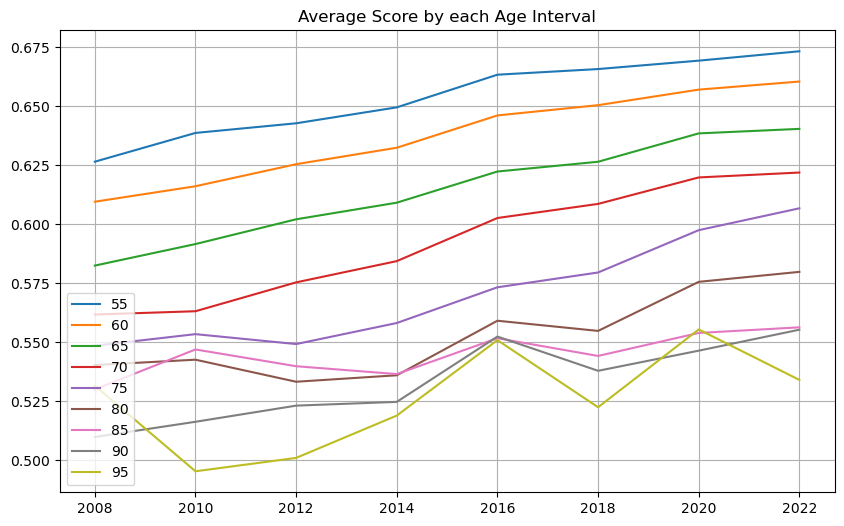

In [88]:
# Score Groupby Age
age_scores = []
for i in range(2, 10):
    age_score = df_scores[i].groupby(by='age_interval')['score'].apply(lambda x: x.mean())
    age_score['year'] = i
    age_scores.append(age_score)
score_stat_age = pd.DataFrame(age_scores)
score_stat_age.set_index(['year'], inplace=True)
score_stat_age.index = list(range(2008, 2024, 2))
score_stat_age.iloc[:, 2:-2].plot(grid=True, legend=True, figsize=(10, 6))
plt.title('Average Score by each Age Interval')
plt.legend(loc='lower left')
score_stat_age.style.background_gradient(cmap='Blues', axis=1)

birth_interval,1905,1910,1915,1920,1925,1930,1935,1940,1945,1950,1955,1960
2008,0.582520,0.503674,0.509302,0.537311,0.539877,0.550736,0.566022,0.586774,0.612957,0.629467,0.643248,0.646775
2010,0.620860,0.462208,0.518756,0.540697,0.543221,0.549151,0.561310,0.585246,0.614120,0.631738,0.649713,0.648805
2012,0.715824,0.501147,0.525772,0.530891,0.536648,0.536981,0.559231,0.585476,0.612573,0.631060,0.647826,0.646576
2014,0.667304,0.662539,0.518851,0.524654,0.536436,0.535925,0.558066,0.584290,0.609050,0.632327,0.649433,0.667199
2016,0.569739,nan,0.525034,0.551154,0.550362,0.554641,0.566158,0.592122,0.615143,0.636293,0.657396,0.672163
2018,nan,nan,0.524971,0.546467,0.539149,0.541230,0.561165,0.583738,0.612650,0.629946,0.654925,0.667060
2020,nan,nan,0.534908,0.550702,0.547122,0.550946,0.571733,0.592563,0.617725,0.632394,0.654462,0.666734
2022,nan,nan,0.489977,0.553259,0.539452,0.556626,0.567130,0.586935,0.612360,0.629607,0.650421,0.664878


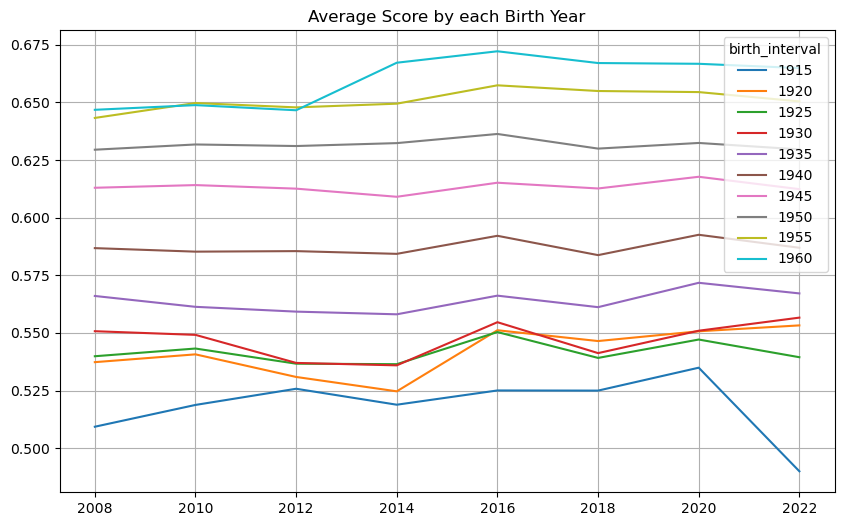

In [87]:
# Score Groupby Birth Year
generation_scores = []
for i in range(2, 10):
    generation_score = df_scores[i].groupby(by='birth_interval')['score'].apply(lambda x: x.mean())
    generation_score['year'] = i
    generation_scores.append(generation_score)
score_stat_generation = pd.DataFrame(generation_scores)
score_stat_generation.set_index(['year'], inplace=True)
score_stat_generation.index = list(range(2008, 2024, 2))
score_stat_generation.iloc[:, 2:].plot(grid=True, legend=True,  figsize=(10, 6))
plt.title('Average Score by each Birth Year')
score_stat_generation.style.background_gradient(cmap='Blues', axis=1)

birth_interval,1905,1910,1915,1920,1925,1930,1935,1940,1945,1950,1955,1960
2008,0.635399,0.506992,0.508716,0.537187,0.541356,0.554387,0.571962,0.592061,0.616620,0.628827,0.638527,0.645418
2010,0.644536,0.485033,0.516745,0.544407,0.544304,0.551896,0.566906,0.590488,0.619986,0.635460,0.651251,0.646425
2012,0.732613,0.525284,0.541705,0.545078,0.534566,0.537436,0.563398,0.590039,0.616703,0.633866,0.647319,0.643728
2014,0.712276,0.752276,0.521654,0.540567,0.532568,0.537165,0.560856,0.590207,0.612764,0.633669,0.648734,0.665235
2016,0.630474,nan,0.553413,0.576824,0.568658,0.571532,0.580616,0.609615,0.629042,0.649069,0.667544,0.679894
2018,nan,nan,0.552167,0.559188,0.556342,0.555002,0.577135,0.596416,0.628314,0.639948,0.663460,0.669872
2020,nan,nan,0.607130,0.579722,0.568545,0.572557,0.592595,0.614249,0.634675,0.645770,0.664861,0.672849
2022,nan,nan,0.476337,0.612064,0.554293,0.589457,0.590595,0.609748,0.630881,0.648393,0.661224,0.670807


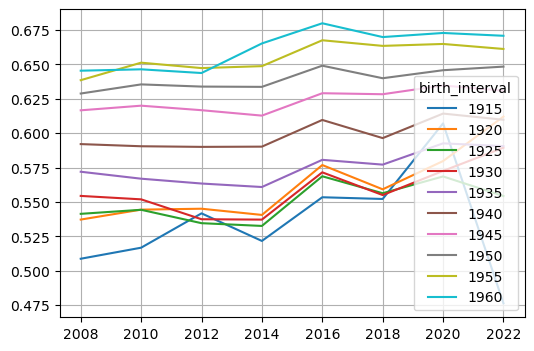

In [66]:
# Score Groupby Birth Year
generation_scores = []
for i in range(2, 10):
    generation_score = df_scores[i].groupby(by='birth_interval')['score_subjective'].apply(lambda x: x.mean())
    generation_score['year'] = i
    generation_scores.append(generation_score)
score_stat_generation = pd.DataFrame(generation_scores)
score_stat_generation.set_index(['year'], inplace=True)
score_stat_generation.index = list(range(2008, 2024, 2))
score_stat_generation.iloc[:, 2:].plot(grid=True, legend=True, figsize=(6, 4))
score_stat_generation.style.background_gradient(cmap='Blues', axis=1)

age_interval,45,50,55,60,65,70,75,80,85,90,95,100,105
2008,0.856527,0.848334,0.830787,0.823474,0.812193,0.794417,0.776894,0.770249,0.748718,0.697558,0.712619,nan,nan
2010,0.861443,0.850099,0.839805,0.833864,0.817857,0.797834,0.788169,0.773850,0.747906,0.682366,0.592560,0.722421,nan
2012,nan,0.854403,0.846395,0.830435,0.817290,0.803130,0.787539,0.760864,0.749805,0.690838,0.581685,0.780357,nan
2014,nan,0.864146,0.856109,0.847024,0.829604,0.812578,0.804818,0.767679,0.760644,0.672056,0.637485,0.605952,0.725000
2016,nan,0.860410,0.855808,0.847974,0.831286,0.814983,0.800409,0.776602,0.745587,0.701712,0.649537,0.644762,0.383333
2018,nan,nan,0.863050,0.851888,0.839960,0.816324,0.799112,0.787133,0.765163,0.686226,0.629677,0.638889,nan
2020,nan,nan,0.849105,0.849540,0.830814,0.818720,0.803338,0.784033,0.756049,0.714551,0.655112,0.448571,nan
2022,nan,nan,0.848731,0.842269,0.827858,0.809030,0.804683,0.778456,0.743545,0.726645,0.624637,0.641429,nan


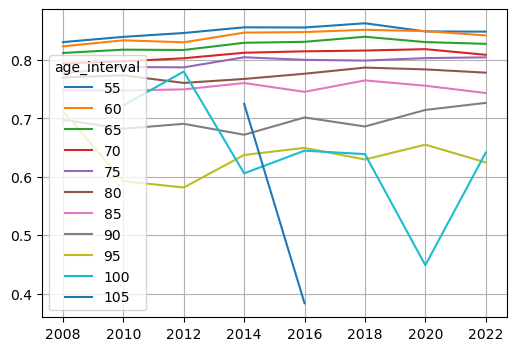

In [55]:
# Score Groupby Birth Year
generation_scores = []
for i in range(2, 10):
    # generation_score = df_scores[i].groupby(by='age_interval')['w0%s' % i + 'iadl'].apply(lambda x: x.mean())
    generation_score = df_scores[i].groupby(by='age_interval')['score_healthp'].apply(lambda x: x.mean())
    generation_score['year'] = i
    generation_scores.append(generation_score)
score_stat_generation = pd.DataFrame(generation_scores)
score_stat_generation.set_index(['year'], inplace=True)
score_stat_generation.index = list(range(2008, 2024, 2))
score_stat_generation.iloc[:, 2:].plot(grid=True, legend=True, figsize=(6, 4))
score_stat_generation.style.background_gradient(cmap='Blues', axis=1)

birth_interval,1905,1910,1915,1920,1925,1930,1935,1940,1945,1950,1955,1960
2008,0.816667,0.675383,0.708487,0.755870,0.771096,0.779889,0.798866,0.813643,0.823116,0.837539,0.849370,0.859718
2010,0.958333,0.579390,0.696674,0.735965,0.765237,0.784619,0.797943,0.816028,0.826892,0.838875,0.849347,0.855568
2012,0.891667,0.515476,0.644835,0.715482,0.756597,0.770581,0.795585,0.811762,0.820279,0.834986,0.850548,0.855590
2014,0.725000,0.605952,0.637485,0.672056,0.760644,0.767679,0.804818,0.812578,0.829604,0.847024,0.856109,0.864146
2016,0.383333,nan,0.581470,0.682053,0.722421,0.771966,0.794290,0.807300,0.824721,0.841474,0.854307,0.857536
2018,nan,nan,0.618254,0.663820,0.709551,0.763794,0.789736,0.804483,0.820461,0.840343,0.856861,0.863730
2020,nan,nan,0.458631,0.643161,0.704567,0.747097,0.782084,0.798466,0.814840,0.828755,0.845342,0.851225
2022,nan,nan,0.825000,0.580704,0.695523,0.724322,0.761795,0.789018,0.805466,0.818875,0.836019,0.841681


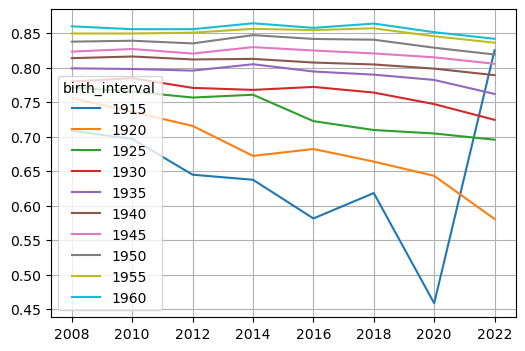

In [56]:
# Score Groupby Birth Year
generation_scores = []
for i in range(2, 10):
    generation_score = df_scores[i].groupby(by='birth_interval')['score_healthp'].apply(lambda x: x.mean())
    generation_score['year'] = i
    generation_scores.append(generation_score)
score_stat_generation = pd.DataFrame(generation_scores)
score_stat_generation.set_index(['year'], inplace=True)
score_stat_generation.index = list(range(2008, 2024, 2))
score_stat_generation.iloc[:, 2:].plot(grid=True, legend=True, figsize=(6, 4))
score_stat_generation.style.background_gradient(cmap='Blues', axis=1)

birth_interval,1905,1910,1915,1920,1925,1930,1935,1940,1945,1950,1955,1960
2008,0.412500,0.448214,0.451957,0.470567,0.479767,0.511280,0.532963,0.548749,0.573992,0.594026,0.605084,0.596925
2010,0.550000,0.392388,0.485891,0.499512,0.489584,0.507158,0.527654,0.546126,0.572433,0.585232,0.602385,0.600346
2012,0.725000,0.390000,0.497191,0.461230,0.495432,0.500744,0.531428,0.560412,0.577937,0.588975,0.599719,0.593767
2014,0.650000,0.675000,0.501829,0.488636,0.518265,0.519118,0.555208,0.569094,0.587956,0.605153,0.613088,0.620649
2016,0.609718,nan,0.535870,0.540135,0.531524,0.550433,0.556281,0.581392,0.598070,0.613243,0.622093,0.622127
2018,nan,nan,0.483333,0.542153,0.514142,0.515456,0.547500,0.579784,0.594088,0.605868,0.617583,0.620378
2020,nan,nan,0.512500,0.564934,0.546659,0.547816,0.568921,0.589311,0.615375,0.616346,0.629924,0.628990
2022,nan,nan,0.450000,0.498958,0.519436,0.546966,0.551890,0.574456,0.590713,0.600827,0.618350,0.620668


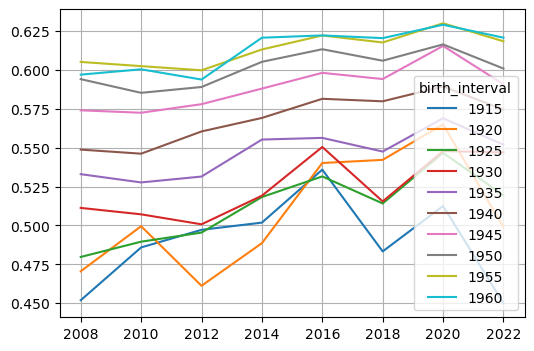

In [57]:
# Score Groupby Birth Year
generation_scores = []
for i in range(2, 10):
    generation_score = df_scores[i].groupby(by='birth_interval')['score_healthm'].apply(lambda x: x.mean())
    generation_score['year'] = i
    generation_scores.append(generation_score)
score_stat_generation = pd.DataFrame(generation_scores)
score_stat_generation.set_index(['year'], inplace=True)
score_stat_generation.index = list(range(2008, 2024, 2))
score_stat_generation.iloc[:, 2:].plot(grid=True, legend=True, figsize=(6, 4))
score_stat_generation.style.background_gradient(cmap='Blues', axis=1)

birth_interval,1905,1910,1915,1920,1925,1930,1935,1940,1945,1950,1955,1960
2008,0.442583,0.413903,0.411043,0.444613,0.418955,0.407484,0.413764,0.467715,0.536473,0.581341,0.619348,0.616612
2010,0.432870,0.321805,0.431395,0.432578,0.433837,0.406543,0.405217,0.461376,0.531056,0.579241,0.621636,0.626882
2012,0.734152,0.546294,0.429740,0.413592,0.424667,0.391060,0.403771,0.455141,0.530910,0.581345,0.623563,0.623480
2014,0.685414,0.581340,0.466466,0.409683,0.414148,0.376581,0.379600,0.437351,0.503128,0.564999,0.616341,0.651341
2016,0.580184,nan,0.411360,0.413712,0.406708,0.353432,0.372807,0.417855,0.484325,0.536028,0.599560,0.650595
2018,nan,nan,0.427832,0.463520,0.397101,0.354743,0.361657,0.408900,0.475707,0.529160,0.598859,0.649626
2020,nan,nan,0.407367,0.406937,0.375985,0.341923,0.368600,0.406649,0.473668,0.526792,0.592186,0.643490
2022,nan,nan,0.264732,0.421393,0.407606,0.346077,0.378833,0.404295,0.480719,0.519175,0.594264,0.650996


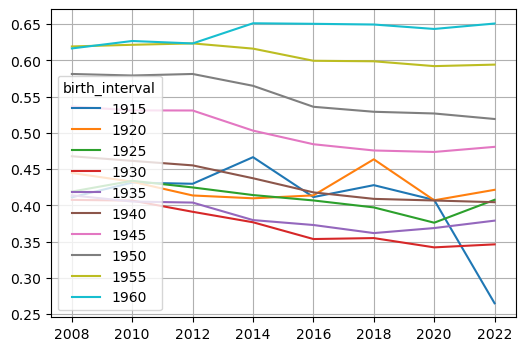

In [58]:
# Score Groupby Birth Year
generation_scores = []
for i in range(2, 10):
    generation_score = df_scores[i].groupby(by='birth_interval')['score_finance'].apply(lambda x: x.mean())
    generation_score['year'] = i
    generation_scores.append(generation_score)
score_stat_generation = pd.DataFrame(generation_scores)
score_stat_generation.set_index(['year'], inplace=True)
score_stat_generation.index = list(range(2008, 2024, 2))
score_stat_generation.iloc[:, 2:].plot(grid=True, legend=True, figsize=(6, 4))
score_stat_generation.style.background_gradient(cmap='Blues', axis=1)

birth_interval,1905,1910,1915,1920,1925,1930,1935,1940,1945,1950,1955,1960
2008,0.446812,0.463926,0.468065,0.478695,0.483774,0.489688,0.494735,0.495842,0.503593,0.507520,0.518076,0.519274
2010,0.447537,0.463952,0.469105,0.479889,0.479892,0.487304,0.492044,0.496480,0.502633,0.508717,0.519329,0.521947
2012,0.445317,0.456267,0.467588,0.476514,0.478223,0.483722,0.489470,0.496335,0.504646,0.507711,0.519503,0.524861
2014,0.428912,0.428912,0.458414,0.464590,0.468157,0.475360,0.481480,0.494473,0.500655,0.506761,0.514990,0.540514
2016,0.462782,nan,0.457919,0.466032,0.467609,0.475168,0.483421,0.491971,0.497857,0.503327,0.513034,0.527468
2018,nan,nan,0.461678,0.465493,0.467029,0.475840,0.481893,0.491073,0.497687,0.504402,0.512260,0.523258
2020,nan,nan,0.472246,0.471700,0.475583,0.480506,0.483880,0.489080,0.499221,0.504181,0.508802,0.518771
2022,nan,nan,0.474732,0.476756,0.475881,0.477812,0.482139,0.488717,0.498458,0.504406,0.509842,0.522447


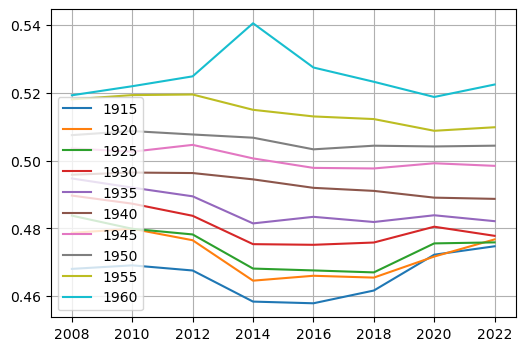

In [61]:
# Score Groupby Birth Year
generation_scores = []
for i in range(2, 10):
    generation_score = df_scores[i].groupby(by='birth_interval')['score_social'].apply(lambda x: x.mean())
    generation_score['year'] = i
    generation_scores.append(generation_score)
score_stat_generation = pd.DataFrame(generation_scores)
score_stat_generation.set_index(['year'], inplace=True)
score_stat_generation.index = list(range(2008, 2024, 2))
score_stat_generation.iloc[:, 2:].plot(grid=True, legend=True, figsize=(6, 4), mark_right=True)
plt.legend(loc='lower left')
score_stat_generation.style.background_gradient(cmap='Blues', axis=1)

In [25]:
stats = []
for i in range(2, 10):
    values_by_group = [df_scores[i][df_scores[i]['birth_interval']==year]['score'] for year in range(1925, 1965, 5)]
    val = life_quality_weighted(values_by_group, epsilon=0.5)
    stats.append(val)

In [26]:
stats = pd.DataFrame(stats)
stats.index = range(2, 10)
stats.columns = ['inter_average', 'inter_inequality', 'intra_inequality', 'adjusted_score']
stats.index = list(range(2008, 2024, 2))
stats

,inter_average,inter_inequality,intra_inequality,adjusted_score
2008,0.596982,0.001093,0.007821,0.591661
2010,0.597913,0.001188,0.007744,0.592573
2012,0.594546,0.001353,0.007222,0.589448
2014,0.596591,0.001594,0.006545,0.591735
2016,0.605535,0.001319,0.005921,0.601150
2018,0.598733,0.001523,0.006224,0.594094
2020,0.604210,0.001259,0.005414,0.600178
2022,0.600926,0.001260,0.005457,0.596889


In [110]:
pivot_df_avg  = score_stat[['mean']].reset_index()
pivot_df_avg = pivot_df_avg.pivot(index='year', columns='score_type', values='mean')
pivot_df_avg.index = list(range(2008, 2024, 2))
pivot_df_avg

score_type,score,score_finance,score_healthm,score_healthp,score_social,score_subjective
2008,0.593531,0.500040,0.553018,0.812936,0.500058,0.595549
2010,0.595671,0.500042,0.553204,0.814647,0.500063,0.599353
2012,0.594847,0.500042,0.557746,0.811470,0.500067,0.597363
2014,0.602264,0.500041,0.579105,0.822154,0.500063,0.604188
2016,0.617228,0.500035,0.593988,0.821840,0.500067,0.630474
2018,0.614070,0.500037,0.589018,0.823124,0.500072,0.625078
2020,0.620349,0.500040,0.605806,0.815553,0.500077,0.635330
2022,0.616313,0.500049,0.591094,0.804497,0.500083,0.633695


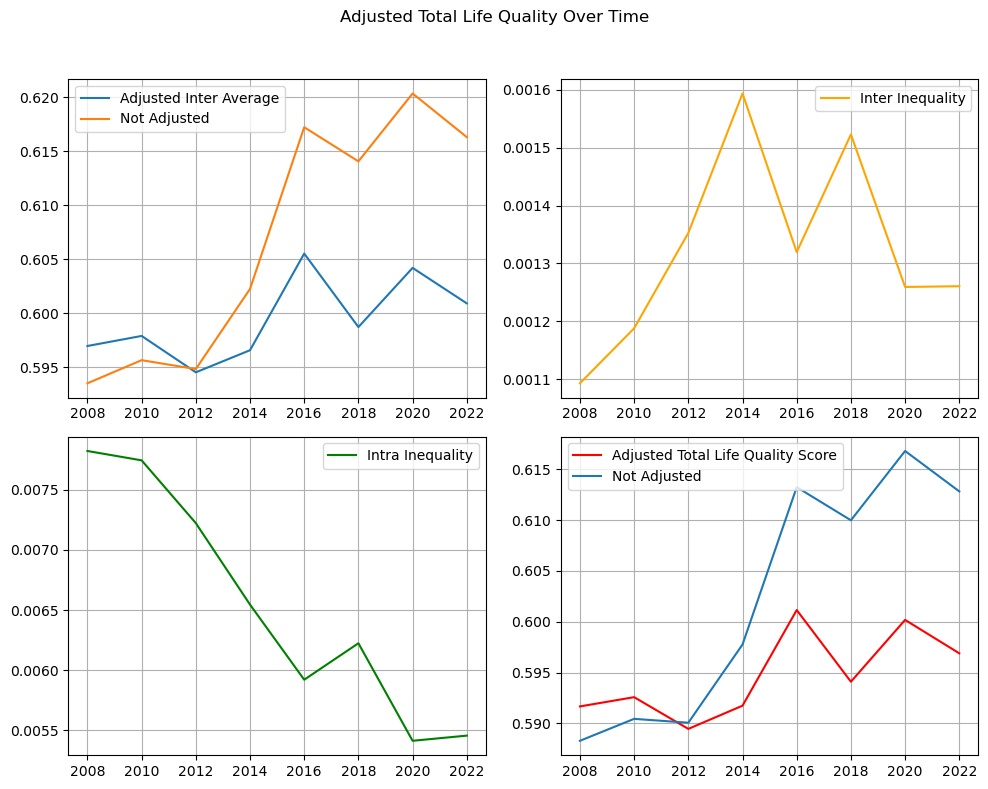

In [114]:
# Plotting the 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# First subplot: Inter Average
axs[0, 0].plot(stats.index, stats['inter_average'], label='Adjusted Inter Average')
axs[0, 0].plot(pivot_df_avg.index, pivot_df_avg['score'], label='Not Adjusted')
axs[0, 0].grid(True)
axs[0, 0].legend()

# Second subplot: Inter Inequality
axs[0, 1].plot(stats.index, stats['inter_inequality'], label='Inter Inequality', color='orange')
axs[0, 1].grid(True)
axs[0, 1].legend()

# Third subplot: Intra Inequality
axs[1, 0].plot(stats.index, stats['intra_inequality'], label='Intra Inequality', color='green')
axs[1, 0].grid(True)
axs[1, 0].legend()

# Fourth subplot: Adjusted Score
axs[1, 1].plot(stats.index, stats['adjusted_score'], label='Adjusted Total Life Quality Score', color='red')
axs[1, 1].plot(pivot_df_multi.index, pivot_df_multi['score'], label='Not Adjusted')
axs[1, 1].grid(True)
axs[1, 1].legend()

# Title and layout adjustments
plt.suptitle('Adjusted Total Life Quality Over Time')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

<Axes: >

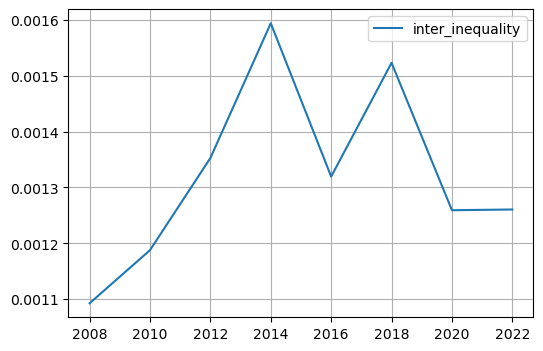

In [91]:
stats['inter_inequality'].plot(grid=True, legend=True, figsize=(6, 4))

<Axes: >

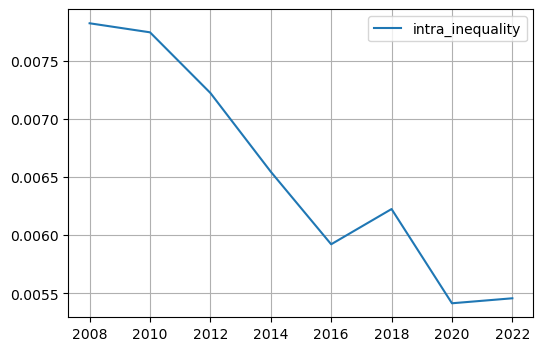

In [92]:
stats['intra_inequality'].plot(grid=True, legend=True, figsize=(6, 4))